In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
import functools
import statsmodels.formula.api as smf
@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()
import scipy.stats as st
import seaborn as sns

In [3]:
df = pd.read_csv('UserAnimeList.csv')

In [4]:
filtered_df = df[['username', 'anime_id', 'my_score']].loc[lambda x: x['my_score'] != 0]

In [5]:
def read_xml(file, username):
    import xml.etree.ElementTree as ET

    xml_data = open(file, 'r').read()  # Read file
    root = ET.XML(xml_data)  # Parse XML

    data = []
    cols = []
    for i, child in enumerate(root):
        data.append([subchild.text for subchild in child])
        cols.append(child.tag)
    new_list = pd.DataFrame(data).T
    new_list.columns = cols

    df = new_list.loc[[0, 9]].T.dropna().rename({0: 'anime_id', 9: 'my_score'}, axis=1)
    df['username'] = username
    df['anime_id'] = df['anime_id'].astype(int)
    df['my_score'] = df['my_score'].astype(int)
    df['username'] = df['username'].astype(str)
    df = df.loc[lambda x: x['my_score'] != 0]
    df = df.reset_index(drop=True)
    return df

def add_user(full_df, xml_file, username):
    user_df = read_xml(xml_file, username)
    without_user = full_df.loc[lambda x: x['username'] != username]
    return pd.concat([without_user, user_df], ignore_index=True)

In [6]:
filtered_df = add_user(filtered_df, 'user_profiles/Fro116.xml', 'Fro116')

In [7]:
average_rating = filtered_df['my_score'].mean()
user_bias = pd.DataFrame(filtered_df.groupby('username')['my_score'].mean()).rename(
    {'my_score': 'user_bias'}, axis=1) - average_rating
anime_bias = pd.DataFrame(filtered_df.groupby('anime_id')['my_score'].mean()).rename(
    {'my_score': 'anime_bias'}, axis=1) - average_rating

In [8]:
filtered_df = filtered_df.merge(anime_bias, on = ['anime_id']).merge(user_bias, on = ['username'])
filtered_df['normalized_score'] = (filtered_df['my_score'] 
    - filtered_df['anime_bias'] - filtered_df['user_bias'] - average_rating)
filtered_df = filtered_df.set_index('username')
filtered_df = filtered_df.dropna()

In [9]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df['delta'] = neighborhood.groupby('anime_id').apply(
        lambda x: np.dot(x['normalized_score'], x['corr']) / x['corr'].abs().sum()) 
    pred_df['blp'] = anime_bias + user_bias.loc[recommendee].squeeze()  + average_rating
    pred_df = pred_df.dropna()    
    return pred_df

In [10]:
def get_correlation(df, recommendee):
    user_subset = df.loc[[recommendee]].merge(df.reset_index(), on = 'anime_id')
    adj_cos_corr_numerator = user_subset.groupby('username').apply(
        lambda x: np.dot(x['normalized_score_x'], x['normalized_score_y']))
    adj_cos_corr_denom = df.groupby('username').apply(
        lambda x: np.sqrt(np.dot(x['normalized_score'], x['normalized_score'])))
    adj_cos_corr_denom *= adj_cos_corr_denom.loc[recommendee]
    adj_cos_corrs = pd.DataFrame((adj_cos_corr_numerator / adj_cos_corr_denom), columns=['corr'])
    adj_cos_corrs = adj_cos_corrs.dropna()
    return adj_cos_corrs

In [11]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[pred_df.index.intersection(df.loc[recommendee].anime_id)]
    recommendee_df = recommendee_df.merge(df.loc[recommendee].set_index('anime_id')['my_score'], on ='anime_id')
    errors = (recommendee_df['my_score'] - recommendee_df['score'])
    return np.dot(errors, errors)

In [12]:
def compute_accuracy_metrics(df, recommendee, neighborhood_sizes):
    # training/test split
    # TODO run k-fold cross validation
    test_split = 0.10
    num_seen_shows = len(df.loc[recommendee])
    oos_indices = random.sample(list(range(num_seen_shows)), int(num_seen_shows * test_split))
    oos_df = df.loc[recommendee].iloc[oos_indices]
    is_df = df.loc[lambda x: ~((x.index.get_level_values('username') == recommendee) & x.anime_id.isin(oos_df.anime_id))]

    # compute correlations
    corrs = get_correlation(is_df, recommendee)
    corrs['similarity'] = corrs['corr'].abs()
    corrs = corrs.sort_values(by='similarity').dropna()
    corrs = corrs.drop(recommendee) # makes insample score more meaningful
    
    metrics = pd.DataFrame()    
    for neighborhood_size in neighborhood_sizes:
        # extract model features
        neighborhood = (df.merge(pd.DataFrame(corrs[-neighborhood_size:]), on = 'username')).dropna()
        pred_df = prepare_prediction(recommendee, neighborhood)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on = ['anime_id'])
        recomendee_seen_shows['target'] = recomendee_seen_shows['my_score'] - recomendee_seen_shows['blp']
        model = lm('target ~ delta + 0', recomendee_seen_shows)
        
        # inference
        pred_df['score'] = model.predict(pred_df) + pred_df['blp']
        is_pred_df = pred_df.loc[lambda x: x.index.isin(df.loc[recommendee].anime_id) & ~x.index.isin(oos_df.anime_id)]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / (len(df.loc[recommendee].anime_id) - len(oos_df))
        oos_coverage = len(oos_pred_df) / len(oos_df)
        
        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index) & ~x.anime_id.isin(oos_df.anime_id)]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]        
        is_se = get_squared_error(df, is_pred_df, recommendee)
        oos_se = get_squared_error(df, oos_pred_df, recommendee)
        missing_is_se = np.dot(missing_is['normalized_score'], missing_is['normalized_score'])
        missing_oos_se = np.dot(missing_oos['normalized_score'], missing_oos['normalized_score'])
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) /  len(oos_df))
        metrics = metrics.append({
            'neighborhood_size': neighborhood_size, 
            'is_rmse': is_rmse, 'is_coverage': is_coverage,
            'oos_rmse': oos_rmse, 'oos_coverage': oos_coverage
            }, ignore_index=True)
    
    return metrics

In [13]:
%%time
from tqdm import tqdm
base = np.sqrt(2)
neighborhood_sizes = [int(base**i) for i in range(int(np.log(len(filtered_df)) / np.log(base))+1)] + [len(filtered_df)]
errors_by_neighborhood_size = []
for i in tqdm(range(10)):
    errors_by_neighborhood_size.append(compute_accuracy_metrics(filtered_df, 'Fro116', neighborhood_sizes))

 10%|█         | 1/10 [20:48<3:07:15, 1248.38s/it]


KeyboardInterrupt: 

In [14]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [15]:
wide_data = pd.melt(allerrors, ['neighborhood_size'])

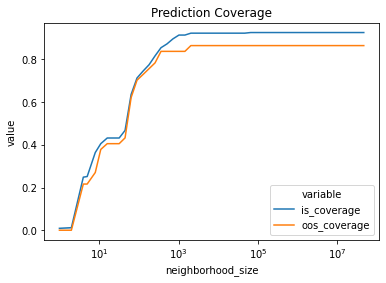

In [16]:
_ = sns.lineplot(x='neighborhood_size', y='value', hue='variable',
    data= wide_data.loc[lambda x: x.variable.isin(['is_coverage', 'oos_coverage'])]).set(
    xscale='log', title='Prediction Coverage')

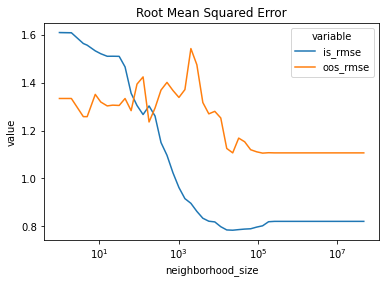

In [17]:
_ = sns.lineplot(x='neighborhood_size', y='value', hue='variable',
    data= wide_data.loc[lambda x: x.variable.isin(['is_rmse', 'oos_rmse'])]).set(
    xscale='log', title='Root Mean Squared Error')

In [18]:
allerrors.groupby('neighborhood_size').mean().sort_values(by='oos_rmse')

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
131072.0,0.926036,0.801385,0.864865,1.105490
46358345.0,0.926036,0.819986,0.864865,1.106522
33554432.0,0.926036,0.819986,0.864865,1.106522
262144.0,0.926036,0.819986,0.864865,1.106522
370727.0,0.926036,0.819986,0.864865,1.106522
524288.0,0.926036,0.819986,0.864865,1.106522
1048576.0,0.926036,0.819986,0.864865,1.106522
1482910.0,0.926036,0.819986,0.864865,1.106522
2097152.0,0.926036,0.819986,0.864865,1.106522
